In [41]:
# source https://towardsdatascience.com/when-to-buy-the-dip-e2e128d737a7
# import packages for use later in the HMM code

import pandas as pd
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import datetime as dt

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns

import os
import alpaca_trade_api as tradeapi

# authentication and connection details
# store your Alpaca API key and secret in your environment
api_key = os.environ.get('alpaca_api_key')
api_secret = os.environ.get('alpaca_api_secret')
base_url = 'https://api.alpaca.markets'

# instantiate REST API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

ticker = ['SPY']
all_historic_data = pd.DataFrame()

for t in ticker:
    ticker_data = api.get_barset(t, 'day', limit=1000).df[t].reset_index()

    ticker_data['date'] = ticker_data['time']
    ticker_data_clean = ticker_data[['date', 'close', 'high', 'low']].copy()
    ticker_data_clean['date'] = pd.to_datetime(ticker_data_clean['date'])
    ticker_data_clean.insert(1, 'ticker', t)
    ticker_data_clean['return'] = ticker_data_clean['close'].pct_change()

    ticker_data_clean['range'] = (ticker_data_clean['high']/ticker_data_clean['low'])-1
    del ticker_data_clean['high']
    del ticker_data_clean['low']
    ticker_data_clean.dropna(how='any', inplace=True)

    
    all_historic_data = pd.concat([all_historic_data, ticker_data_clean])

all_historic_data.head()

,date,ticker,close,return,range
1,2016-12-22 00:00:00-05:00,SPY,225.43,-0.001683,0.003646
2,2016-12-23 00:00:00-05:00,SPY,225.69,0.001153,0.002265
3,2016-12-27 00:00:00-05:00,SPY,226.24,0.002437,0.003230
4,2016-12-28 00:00:00-05:00,SPY,224.43,-0.008000,0.010345
5,2016-12-29 00:00:00-05:00,SPY,224.37,-0.000267,0.004691


In [42]:
#create train and test sets
#this methodology will randomly select 80% of our data

msk = np.random.rand(len(all_historic_data)) < 0.8
train = all_historic_data[msk]
test = all_historic_data[~msk]

In [43]:
X_train = train[['date', 'return', 'range', 'close']].set_index('date')
X_test = test[['date', 'return', 'range', 'close']].set_index('date')

model = mix.GaussianMixture(n_components=3, 
                            covariance_type='full', 
                            n_init=100, 
                            random_state=7).fit(X_train)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X_test)

print('Means and vars of each hidden state')
for i in range(model.n_components):
    print('{0}th hidden state'.format(i))
    print('mean = ', model.means_[i])
    print('var = ', np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [1.40515687e-03 6.13603517e-03 2.76166412e+02]
var =  [1.98093314e-05 7.19445203e-06 1.00460888e+03]

1th hidden state
mean =  [-5.32698982e-04  1.62084057e-02  2.91884425e+02]
var =  [1.58663618e-04 4.12439226e-05 8.99143723e+02]

2th hidden state
mean =  [-6.44466090e-03  4.40653818e-02  2.76966118e+02]
var =  [1.78583192e-03 4.44888947e-04 6.66102128e+02]



In [44]:
# 1:low vol regime - lowest variance for return. return is positive so signal is long
# 2:high vol regime - highest variance for return. return is positive so long conservatively because of high variance
# 0:neutral vol regime - 2nd lowest variance. return is positive so long conservatively or stay out stocks

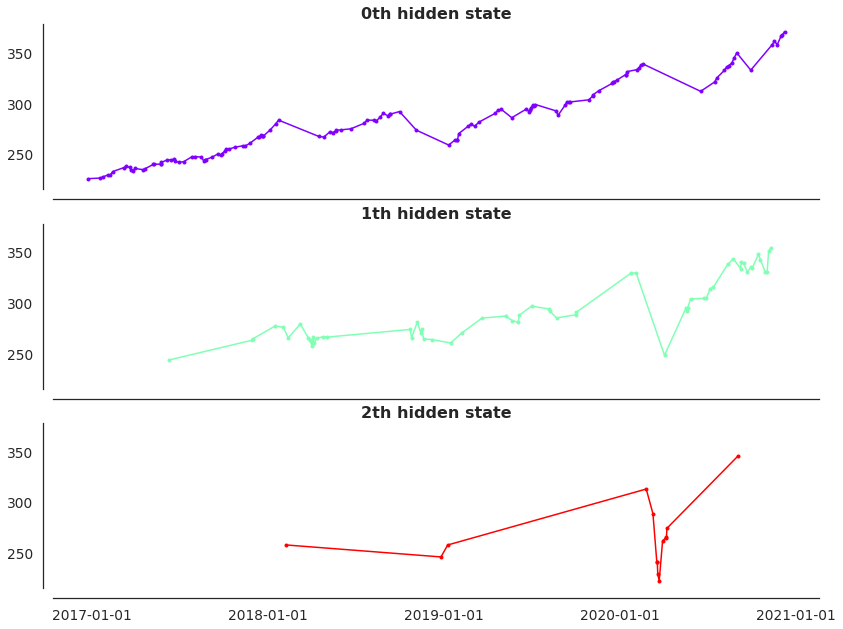

In [45]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(X_test.index.values[mask],
                 X_test["close"].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout();

In [47]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=X_test.index)
          .join(X_test, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
states.head()

,date,states,return,range,close
0,2016-12-23 00:00:00-05:00,0,0.001153,0.002265,225.69
1,2017-01-17 00:00:00-05:00,0,-0.003259,0.004340,226.29
2,2017-01-24 00:00:00-05:00,0,0.006190,0.007999,227.58
3,2017-02-03 00:00:00-05:00,0,0.007025,0.004771,229.37
4,2017-02-07 00:00:00-05:00,0,0.000000,0.004091,228.97


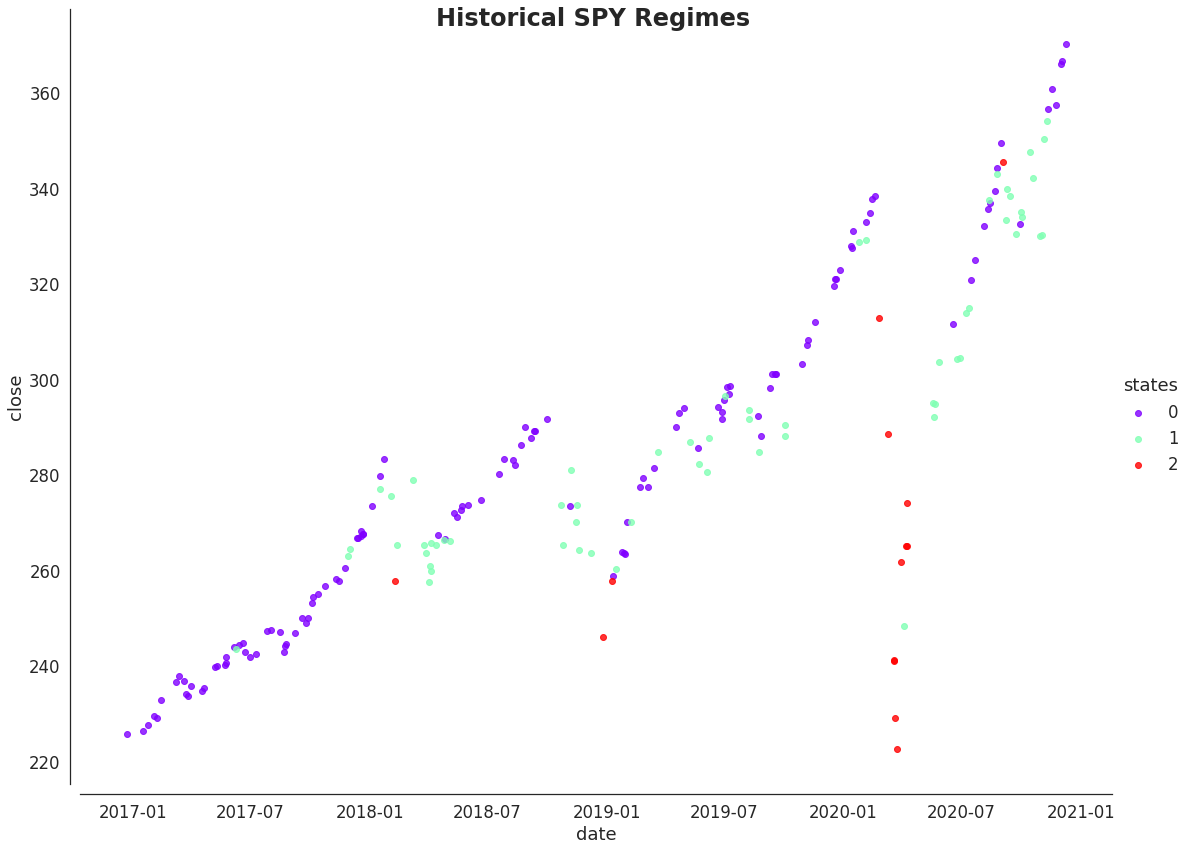

In [46]:
sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'date', "close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi');